# Saving Experiments #

First, it's important that we keep track of all hyperparameters etc. from each experiment. There's nothing more infuriating than losing the setup for a successful experiment then having to retrace your steps to recreate it.

In [1]:
import torch

import os
import yaml
import pandas as pd

from datetime import datetime


class Experiment:
	def __init__(self, name, num_epochs, dataset, optimizer, pretrained_model=None, batch_size=8, lr=1e-4, new_experiment=True, **hyperparameters):
		self.dirpath = os.path.join("experiments", f"{name}_{datetime.now().strftime("%Y-%m-%d")}")
		self.config = {
			"experiment_name": name,
			"num_epochs": num_epochs,
			"dataset": dataset,
			"optimizer": optimizer,
			"hyperparameters": {
				"batch_size": batch_size,
				"learning_rate": lr,
				**hyperparameters
			}
		}

		if pretrained_model is not None:
			self.config["pretrained_model"] = pretrained_model
		
		if new_experiment:
			if not os.path.isdir(self.dirpath):
				os.mkdir(self.dirpath)
			
			if not os.path.isdir(os.path.join(self.dirpath, "checkpoints")):
				os.mkdir(os.path.join(self.dirpath, "checkpoints"))

			self.log_filepath = os.path.join(self.dirpath, f"log.csv")
			with open(self.log_filepath, "w+") as f:
				f.write("epoch,avg train loss,avg test loss,test accuracy,test f1,timestamp\n")

			with open(os.path.join(self.dirpath, "config.yml"), "w+") as f:
				yaml.dump(self.config, f)
	
	def log_epoch(self, epoch, avg_train_loss, avg_test_loss, accuracy, f1, model):
		with open(self.log_filepath, "a") as f:
			f.write(f"{epoch + 1},{avg_train_loss:.4f},{avg_test_loss:.4f},{accuracy:.4f},{f1:.4f},{datetime.now()}\n")
		
		torch.save(model.state_dict(), os.path.join(self.dirpath, "checkpoints", f"checkpoint_{epoch + 1:03}.pt"))

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Usually I would just default to cuda, but my PC doesn't have a cuda capable GPU

# GPT-2 #
The simplest model to begin pretraining with is GPT-2.

# Dataset #

We'll begin with a simple, randomly sampled pandas-based dataset. 

In [3]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split

class SentenceDataset(Dataset):
	def __init__(self, df):
		self.df = df

	def __len__(self):
		return self.df.shape[0]

	def __getitem__(self, idx):
		return self.df.iloc[idx]["tokens"].squeeze(), self.df.iloc[idx]["numerical_label"]

def pad_collate(batch):
	tokens, labels = zip(*batch)
	tokens = pad_sequence(tokens, batch_first=True)

	return tokens, torch.tensor(labels, dtype=torch.long)

# Simple Training #

A first pass at simple, no frills training (no learning rate scheduler or fancy samplers etc).

In [4]:
import numpy as np

from tqdm import tqdm

# macro f1 score provides a good alternative to accuracy in the face of label imbalance. If the model is biased towards a particular label, it's accuracy may be high but it's f1 will be low
from sklearn.metrics import accuracy_score, f1_score

def run_experiment(experiment, train_dataloader, test_dataloader, opt, criterion, model, num_epochs):
	test_df = test_dataloader.dataset.df
	batch_size = test_dataloader.batch_size

	for epoch in range(num_epochs):
		total_train_loss = 0
		model.train()
		pbar = tqdm(enumerate(train_dataloader), total=len(train_dataloader))
		for i, (tokens, label) in pbar:
			tokens = tokens.to(device)
			label = label.to(device)

			pred = model(input_ids=tokens, attention_mask=(tokens > 0)).logits

			opt.zero_grad()
			loss = criterion(pred, label)
			loss.backward()
			opt.step()

			total_train_loss += loss.data
			pbar.set_description(f"Average loss: {total_train_loss / (i + 1)}")
		
		model.eval()
		preds = np.zeros(len(test_dataloader.dataset), dtype=np.int32)
		with torch.no_grad():
			total_test_loss = 0
			for i, (tokens, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
				tokens = tokens.to(device)
				label = label.to(device)
				pred = model(input_ids=tokens, attention_mask=(tokens > 0)).logits

				loss = criterion(pred, label)
				total_test_loss += loss.data

				pred = pred.argmax(1).cpu().numpy()
				label = label.cpu().numpy()
				if i < len(test_dataloader) - 1:
					preds[i * batch_size:(i + 1) * batch_size] = pred
				else:
					preds[i * batch_size:] = pred
		
		experiment.log_epoch(
			epoch,
			total_train_loss / len(train_dataloader), total_test_loss / len(test_dataloader),
			accuracy_score(test_df["numerical_label"], preds), f1_score(test_df["numerical_label"], preds, average="macro"),
			model
		)


In [5]:
from torch.optim import Adam
from torch import nn
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

num_epochs = 4
batch_size = 8  # Small batch size and few epochs due to hardware limitations
lr = 1e-3

experiment = Experiment(
	"simple_training", num_epochs=2, dataset="Sentences_66Agree.csv", optimizer="SGD", pretrained_model="GPT2", batch_size=batch_size, lr=lr
)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=3).to(device)
model.config.pad_token_id = 0

df = pd.read_csv(os.path.join("data", "Sentences_66Agree.csv"))
df["tokens"] = df["sentence"].apply(lambda s: tokenizer(s, return_tensors="pt").input_ids)

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)
train_df = train_df.reset_index()
test_df = test_df.reset_index()

train_dataset = SentenceDataset(train_df)
test_dataset = SentenceDataset(test_df)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=pad_collate)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=pad_collate, shuffle=False)  # Don't want to shuffle test dataset after each epoch

opt = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss().to(device)

run_experiment(experiment, train_dataloader, test_dataloader, opt, criterion, model, num_epochs)

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Analysing Results #

First, we load the most successful epoch, assessed by performance on the testing set. In this case, I use macro f1 score as it more heavily punishes biased outputs (i.e. a model could predict neutral with extreme bias and still attain a reasonable accuracy score).

In [40]:
results_df = pd.read_csv(os.path.join("experiments/simple_training_2024-05-05", "log.csv"))
best_epoch = results_df["test f1"].argmax()

model.load_state_dict(torch.load(os.path.join("experiments/simple_training_2024-05-05", "checkpoints", f"checkpoint_{best_epoch + 1:03}.pt")))
model.eval()

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=3, bias=False)
)

In [41]:
import torch.nn.functional as F

def get_preds(df, batch_size):
	dataset = SentenceDataset(df)
	dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=pad_collate, shuffle=False)

	preds = np.zeros((len(dataloader.dataset), 3))
	with torch.no_grad():
		for i, (tokens, _) in tqdm(enumerate(dataloader), total=len(dataloader)):
			tokens = tokens.to(device)
			pred = F.softmax(model(input_ids=tokens, attention_mask=(tokens > 0)).logits, dim=-1).cpu().numpy()
			if i < len(dataloader) - 1:
				preds[i * batch_size:(i + 1) * batch_size] = pred
			else:
				preds[i * batch_size:] = pred
	
	df[['pred_0', 'pred_1', 'pred_2']] = preds
	df['pred'] = preds.argmax(1)

get_preds(test_df, batch_size)
get_preds(train_df, batch_size)

100%|██████████| 422/422 [03:05<00:00,  2.27it/s]


One of my concerns with how imbalanced the dataset is was that the model would become biased towards neutral labels. Interestingly, it seems the opposite has happened, with the model actually predicting *fewer* neutral labels than are in the test set.

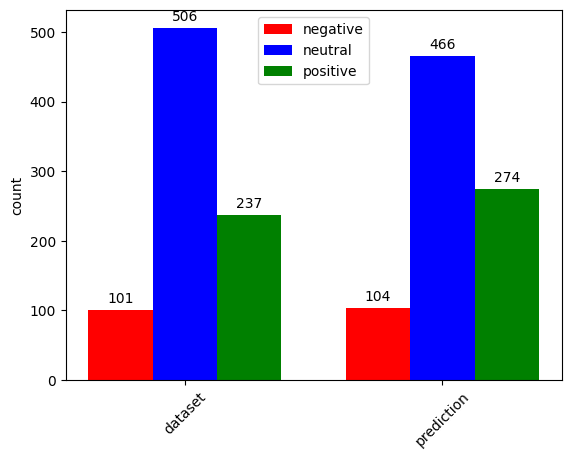

<Figure size 640x480 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt

def display_pred_counts(df, pred_col):
	width = 0.25

	colors = ['red', 'blue', 'green']

	for label, row in df.groupby("numerical_label").count().iterrows():
		offset = width * label
		bar = plt.bar(offset, row["sentence"], width, color=colors[label])
		plt.bar_label(bar, padding=3)

	for pred, row in df.groupby(pred_col).count().iterrows():
		offset = width * pred + 1
		bar = plt.bar(offset, row["sentence"], width, color=colors[pred])
		plt.bar_label(bar, padding=3)

	plt.ylabel("count")
	plt.xticks(np.arange(2) + width, ["dataset", "prediction"], rotation=45)
	plt.legend(["negative", "neutral", "positive"])

	plt.figure().tight_layout()

display_pred_counts(test_df, "pred")

Looking at the confusion matrix, the model clearly suffers from a bias away from neutral towards positive.

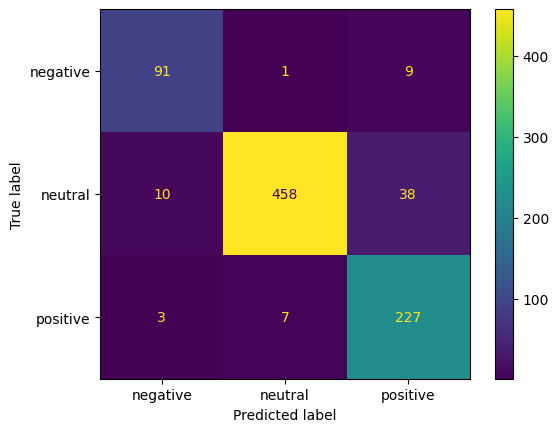

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def display_confusion_matrix(df, pred_col):
	cmatrix = confusion_matrix(df["numerical_label"], df[pred_col])

	display = ConfusionMatrixDisplay(cmatrix, display_labels=["negative", "neutral", "positive"])
	display.plot()

display_confusion_matrix(test_df, "pred")

### ROC curves ###

Looking at the one-vs-rest ROC curves, the model is very confident (high area under curve) for all classes. Given the model's above bias, this isn't actually a great sign.

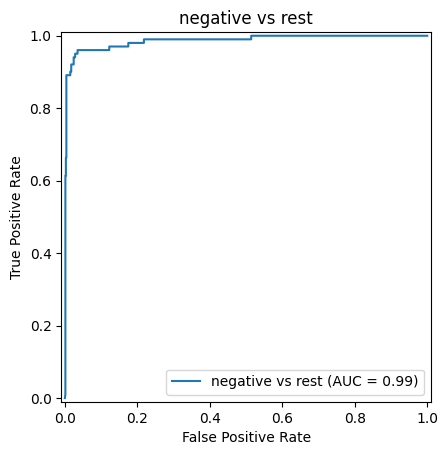

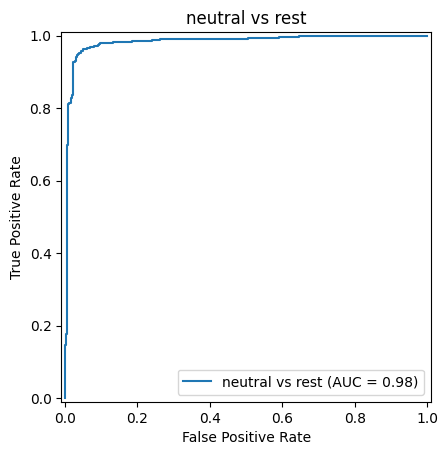

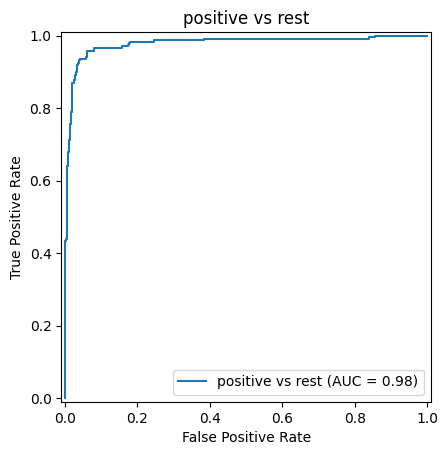

In [44]:
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

def plot_roc_curves(df):
	lb = LabelBinarizer()
	lb.fit(df["label"])

	one_hot_test = lb.transform(df["label"])

	for i, label in enumerate(["negative", "neutral", "positive"]):
		id = np.flatnonzero(lb.classes_ == label)
		display = RocCurveDisplay.from_predictions(
			one_hot_test[:, id],
			df[f"pred_{i}"],
			name=f"{label} vs rest",
		)
		display.ax_.set(
			xlabel="False Positive Rate",
			ylabel="True Positive Rate",
			title=f"{label} vs rest"
		)
		
plot_roc_curves(test_df)

Nevertheless, we'll try calculating optimal threshold values for each class (find the threshold which maximises one-vs-rest F1 score). We'll use the train set for this (don't want to over-tune on the test set).

In [45]:
from sklearn.metrics import precision_recall_curve

def find_thresholds(df):
	lb = LabelBinarizer()

	precision = np.empty(3, dtype=object)
	recall = np.empty(3, dtype=object)
	thresholds = np.empty(3, dtype=object)

	lb.fit(df["label"])
	one_hot_train = lb.transform(df["label"])

	for i, label in enumerate(["negative", "neutral", "positive"]):
		label_id = np.flatnonzero(lb.classes_ == label)
		precision[i], recall[i], thresholds[i] = precision_recall_curve(one_hot_train[:, label_id], df[f"pred_{i}"])
		f1 = 2 * precision[i] * recall[i] / (precision[i] + recall[i] + 1e-4)
		thresholds[i] = thresholds[i][np.argmax(f1)]
	return thresholds

thresholds = find_thresholds(train_df)

If the prediction fails all thresholds (or passes multiple), we select the one which is closest.

In [46]:
pred_cols = ["pred_0", "pred_1", "pred_2"]
test_df["threshold_pred"] = (test_df[pred_cols] - thresholds).T.idxmax().T.str[-1].astype(int)

Using these new thresholded predictions, the model performs significantly better. Particularly, notice the difference between the two confusion matrices. The model still seems to be occasionally confused between neutral and positive, but the confusion is significantly reduced.

In [47]:
print(f"Un-thresholded accuracy: {accuracy_score(test_df["numerical_label"], test_df["pred"]):.4f}")
print(f"Thresholded accuracy: {accuracy_score(test_df["numerical_label"], test_df["threshold_pred"]):.4f}")

print(f"Un-thresholded F1: {f1_score(test_df["numerical_label"], test_df["pred"], average="macro"):.4f}")
print(f"Thresholded F1: {f1_score(test_df["numerical_label"], test_df["threshold_pred"], average="macro"):.4f}")

Un-thresholded accuracy: 0.9194
Thresholded accuracy: 0.9372
Un-thresholded F1: 0.9062
Thresholded F1: 0.9269


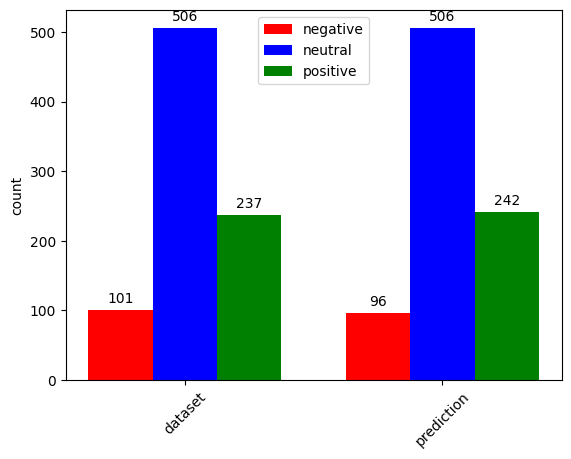

<Figure size 640x480 with 0 Axes>

In [48]:
display_pred_counts(test_df, "threshold_pred")

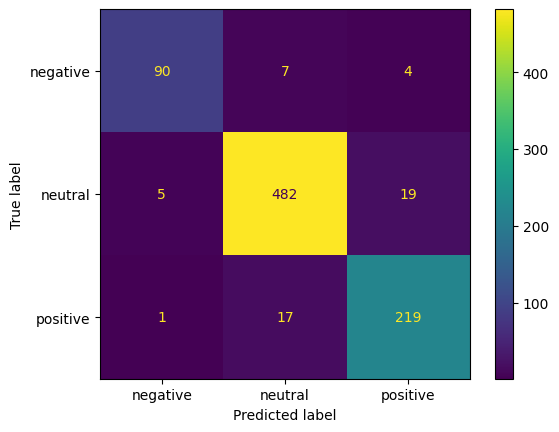

In [49]:
display_confusion_matrix(test_df, "threshold_pred")

### Training with under-sampling ###

Another approach to dealing with imbalanced data is to under-sample the larger classes. In this case, that means using each negative sentence exactly once per epoch and selecting equal sized random subsets of neutral and positive sentences. That way each class is represented with the same frequency during the model's training.

In [50]:
from torch.utils.data import Sampler

class UnderSampler(Sampler):
	def __init__(self, df):
		self.indices_by_label = np.empty(3, dtype=object)

		for i in range(3):
			self.indices_by_label[i] = np.array(df.loc[df["numerical_label"] == i].index)
		
		self.min_label = np.argmin(map(lambda x: len(x), self.indices_by_label))
		self.min_label_size = len(self.indices_by_label[self.min_label])
	
	def __len__(self):
		return self.min_label_size * 3
	
	def __iter__(self):
		self.indices = np.concatenate((
			self.indices_by_label[self.min_label],
			np.random.choice(self.indices_by_label[(self.min_label + 1) % 3], self.min_label_size, replace=False),
			np.random.choice(self.indices_by_label[(self.min_label + 2) % 3], self.min_label_size, replace=False)
		))
		np.random.shuffle(self.indices)

		for index in self.indices:
			yield index

In [18]:
num_epochs = 8  # Can increase number of epochs as each epoch is smaller
batch_size = 8
lr = 1e-3

experiment = Experiment(
	"under_sampling", num_epochs=2, dataset="Sentences_66Agree.csv", optimizer="SGD", pretrained_model="GPT2", batch_size=batch_size, lr=lr
)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=3).to(device)
model.config.pad_token_id = 0

df = pd.read_csv(os.path.join("data", "Sentences_66Agree.csv"))
df["tokens"] = df["sentence"].apply(lambda s: tokenizer(s, return_tensors="pt").input_ids)

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True)
train_df = train_df.reset_index()
test_df = test_df.reset_index()

train_dataset = SentenceDataset(train_df)
test_dataset = SentenceDataset(test_df)

train_sampler = UnderSampler(train_df)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=pad_collate, sampler=train_sampler)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=pad_collate, shuffle=False)  # Don't want to under sample test set

opt = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss().to(device)

run_experiment(experiment, train_dataloader, test_dataloader, opt, criterion, model, num_epochs)

c:\Python312\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
results_df = pd.read_csv(os.path.join("experiments/under_sampling_2024-05-05", "log.csv"))
best_epoch = results_df["test f1"].argmax()

model.load_state_dict(torch.load(os.path.join("experiments/under_sampling_2024-05-05", "checkpoints", f"checkpoint_{best_epoch + 1:03}.pt")))
model.eval()

<All keys matched successfully>

In [52]:
get_preds(test_df, batch_size)
get_preds(train_df, batch_size)

100%|██████████| 422/422 [03:09<00:00,  2.22it/s]


Interestingly, with under sampling the model actually performs slightly worse than without. We'll see below if thresholding makes a more significant impact.

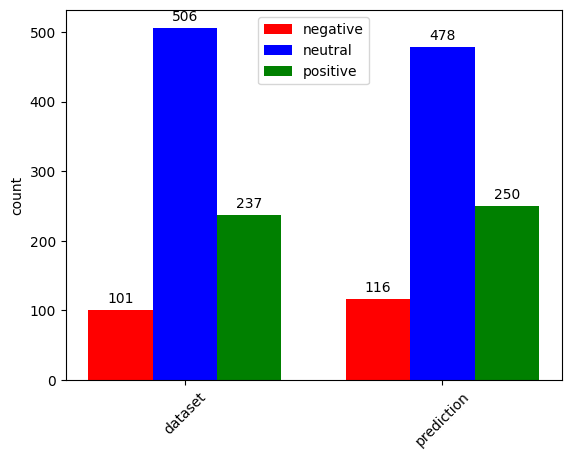

<Figure size 640x480 with 0 Axes>

In [53]:
display_pred_counts(test_df, "pred")

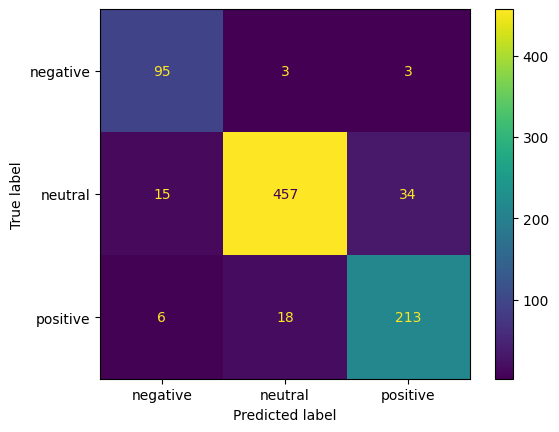

In [54]:
display_confusion_matrix(test_df, "pred")

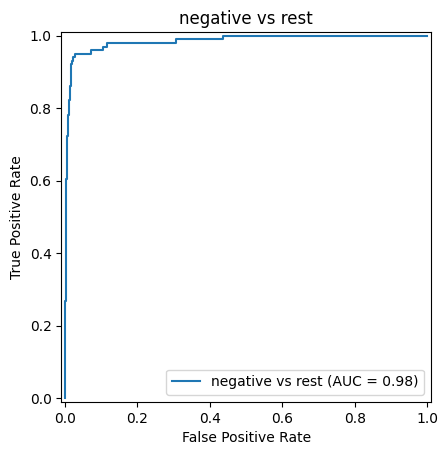

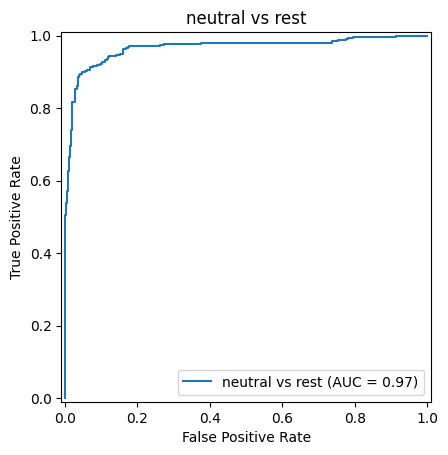

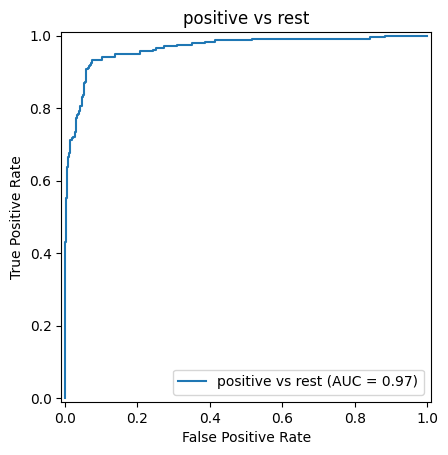

In [55]:
plot_roc_curves(test_df)

In [56]:
pred_cols = ["pred_0", "pred_1", "pred_2"]

In [58]:
thresholds = find_thresholds(train_df)
test_df["threshold_pred"] = (test_df[pred_cols] - thresholds).T.idxmax().T.str[-1].astype(int)

Again, even with thresholding, the model trained using under sampling performs worse than the model trained without. Disappointing, but it was still worth the try to see if there would have been an improvement.

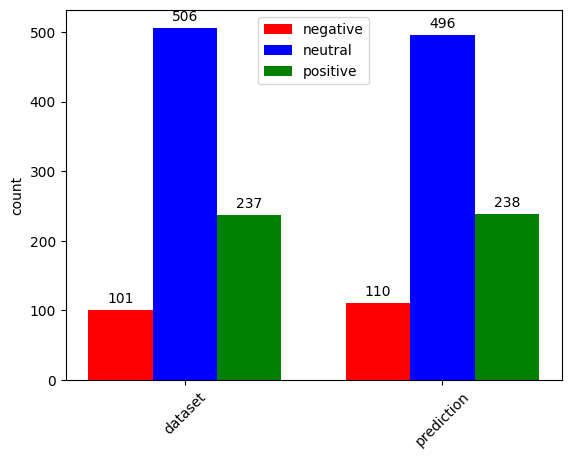

<Figure size 640x480 with 0 Axes>

In [59]:
display_pred_counts(test_df, "threshold_pred")

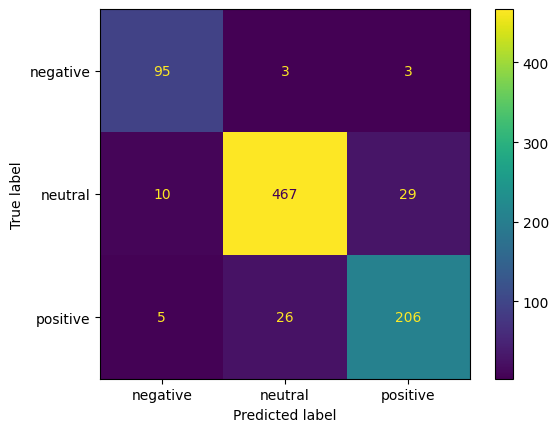

In [60]:
display_confusion_matrix(test_df, "threshold_pred")

In [62]:
print(f"Un-thresholded accuracy: {accuracy_score(test_df["numerical_label"], test_df["pred"]):.4f}")
print(f"Thresholded accuracy: {accuracy_score(test_df["numerical_label"], test_df["threshold_pred"]):.4f}")

print(f"Un-thresholded F1: {f1_score(test_df["numerical_label"], test_df["pred"], average="macro"):.4f}")
print(f"Thresholded F1: {f1_score(test_df["numerical_label"], test_df["threshold_pred"], average="macro"):.4f}")

Un-thresholded accuracy: 0.9064
Thresholded accuracy: 0.9100
Un-thresholded F1: 0.8931
Thresholded F1: 0.9000
